In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping



In [4]:
import pandas as pd

# Especifica la ruta del archivo usando barras invertidas dobles
data_path = 'Petroleo.xls'

# Leer el archivo Excel
data = pd.read_excel(data_path)

# Mostrar las primeras filas y los nombres de las columnas
print(data.head())
print(data.columns)


  Periodos  Mineria
0  1984/01   2629.0
1  1984/02   2714.0
2  1984/03   2667.0
3  1984/04   2781.0
4  1984/05   2801.0
Index(['Periodos', 'Mineria'], dtype='object')


In [5]:
# Mapa para convertir abreviaturas de meses en español a inglés
# Crear un DataFrame de ejemplo
data = pd.DataFrame({
    'Fecha': ['1984/01', '1984/02', '1984/03', '1984/04', '1984/05', 
              '1984/06', '1984/07', '1984/08', '1984/09', '1984/10'],
    'Valor': [2629, 2714, 2667, 2781, 2801, 2816, 2728, 2571, 2599, 2564]
})

# Función para convertir formato de fecha 'YYYY/MM' a ordinal
def convertir_fecha_ordinal(fecha):
    fecha_dt = datetime.strptime(fecha, '%Y/%m')  # Convertir a objeto datetime
    fecha_ordinal = fecha_dt.toordinal()  # Convertir a número ordinal
    return fecha_ordinal

# Aplicar la conversión a la columna 'Fecha'
data['Fecha_ordinal'] = data['Fecha'].apply(convertir_fecha_ordinal)

# Mostrar las primeras filas para verificar la conversión
print(data.head())

     Fecha  Valor  Fecha_ordinal
0  1984/01   2629         724276
1  1984/02   2714         724307
2  1984/03   2667         724336
3  1984/04   2781         724367
4  1984/05   2801         724397


In [51]:
# Normalización de datos
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

data['Fecha_ordinal_scaled'] = scaler_x.fit_transform(data[['Fecha_ordinal']])
data['Cierre_scaled'] = scaler_y.fit_transform(data[['Valor']])


X_scaled = scaler_x.fit_transform(data[['Fecha_ordinal']])
y_scaled = scaler_y.fit_transform(data[['Valor']])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)



In [77]:
# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitorear la pérdida de validación
    patience=100,          # Número de épocas sin mejora tras las cuales entrenamiento será detenido
    restore_best_weights=True  # Restaurar los mejores pesos encontrados durante el entrenamiento
)

# Reshape para LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))

# Construir el modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(1, 1), return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con EarlyStopping
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    validation_data=(X_test, y_test), 
    batch_size=32,
    callbacks=[early_stopping]  # Añadir el callback aquí
)


Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.1859 - val_loss: 0.1805
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1768 - val_loss: 0.1607
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1682 - val_loss: 0.1411
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1254 - val_loss: 0.1220
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1129 - val_loss: 0.1041
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0896 - val_loss: 0.0899
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0944 - val_loss: 0.0810
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0749 - val_loss: 0.0774
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0728 - val_loss: 0.0762
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0689 - val_loss: 0.0747
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0689 - val_loss: 0.0724
Epoch 12/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0704 - val_l

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


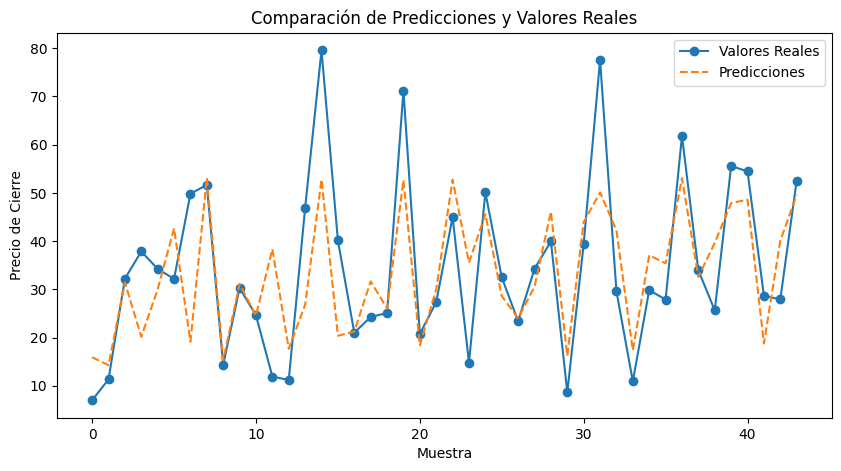

In [78]:
# Hacer predicciones
y_pred = model.predict(X_test)

# Desnormalizar las predicciones y los valores reales
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Valores Reales', marker='o')
plt.plot(y_pred_rescaled, label='Predicciones', linestyle='--')
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Muestra')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()



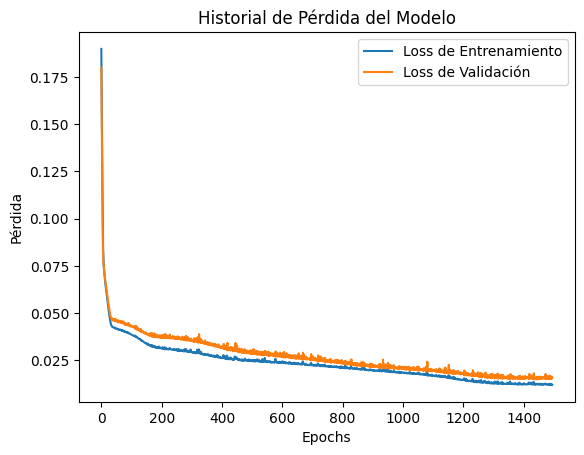

In [60]:


# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.title('Historial de Pérdida del Modelo')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [63]:
# Asegúrate de que los datos de prueba están en el formato correcto
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, 1))

# Hacer predicciones con el modelo
y_pred = model.predict(X_test_reshaped)

# Suponiendo que tienes un objeto 'scaler_y' usado para normalizar los precios de cierre
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [64]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.2f}")



RMSE: 8.87


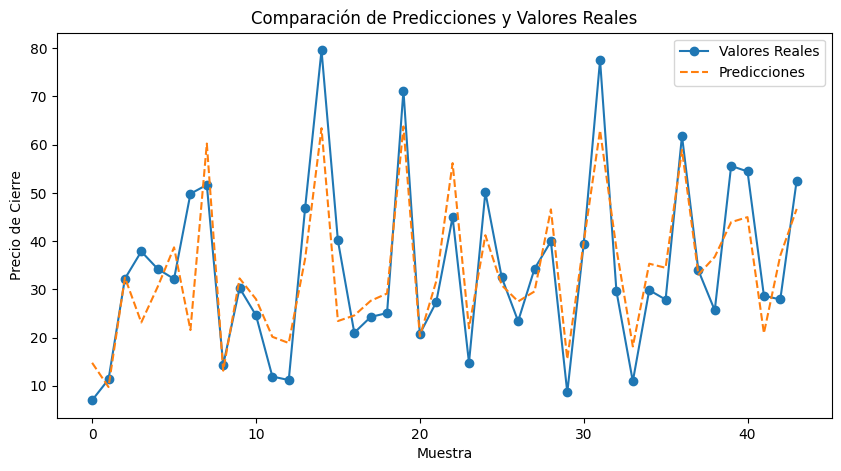

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Valores Reales', marker='o')
plt.plot(y_pred_rescaled, label='Predicciones', linestyle='--')
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Muestra')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()
